In [1]:
import numpy as np
import matplotlib.pyplot as plt

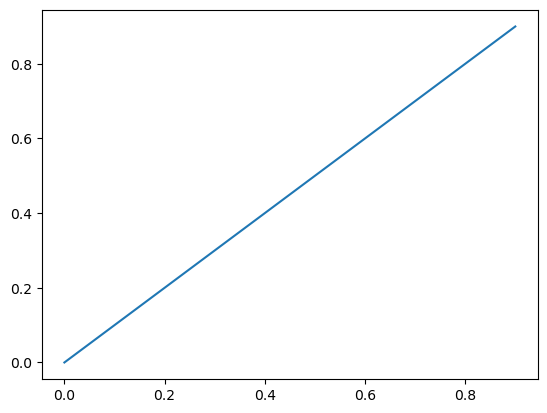

In [2]:
plt.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1))

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
# import scipy.io as sio
# import pandas as pd
# import datetime
# import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
# import math
# import random

# import time

In [13]:
import time

In [3]:
epochs = 200
rTrain = 0.7;
rTest = 0.2;
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

In [4]:
int(0.5 * 200)

100

In [19]:
def normalize(v):
    norm = np.linalg.norm(v)
    junk = 0
    if norm == 0: 
       return v, junk, norm
    return v / norm, junk, norm

def bunch_normalization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = normalize(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [16]:
class TwoDetectorDNN(nn.Module):
    def __init__(self, nTimesteps, nLS1d, nCorr):
        super(TwoDetectorDNN, self).__init__()
        
        self.nBottleneck = nLS1d + nCorr;
        self.nTimesteps = nTimesteps;
        
        # AE piece 1: transform within the signals of each detector
        self.AE_det0 = nn.Sequential(
            nn.Linear(nTimesteps, int(0.5 * nTimesteps)),
            nn.ReLU()
        )
        self.AE_det1 = nn.Sequential(
            nn.Linear(nTimesteps, int(0.5 * nTimesteps)),
            nn.ReLU()
        )
        
        # AE piece 2: join the two detectors
        self.jointLayer1 = nn.Sequential(
            nn.Linear(nTimesteps, self.nBottleneck), #2*nTimesteps),
            nn.ReLU()
        )
        
        # DE piece 1: 
        self.jointLayer2 = nn.Sequential(
            nn.Linear(self.nBottleneck, nTimesteps),
            nn.ReLU()
        )
        
        # DE piece 2:
        self.DE_det0 = nn.Sequential(
            nn.Linear(int(0.5 * nTimesteps), nTimesteps),
            nn.Tanh()
        )
        self.DE_det1 = nn.Sequential(
            nn.Linear(int(0.5 * nTimesteps), nTimesteps),
            nn.Tanh()
        )
        
    def forward(self, x):
#         batch_size = x.shape[0]
        
        det0 = x[:, :self.nTimesteps];
        det1 = x[:, self.nTimesteps:]
        
        det0 = self.AE_det0(det0);
        det1 = self.AE_det1(det1);
        
        x = torch.cat([det0, det1], dim=1);
        x = self.jointLayer1(x);
        x = self.jointLayer2(x);
        
        det0 = x[:, :int(0.5*self.nTimesteps)]
        det1 = x[:, int(0.5*self.nTimesteps):]
        
        det0 = self.DE_det0(det0);
        det1 = self.DE_det1(det1);
        
        return torch.cat([det0, det1], dim=1)

In [82]:
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(201, 40),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(40, 201),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return encoded, decoded

In [6]:
renorm_factor = 20;

In [8]:
realbkg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'] / renorm_factor;
realbbh = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy") / renorm_factor;

In [60]:
realbkg = np.load('../Data_cached/real_bkg_2det_1e6_6000s_4000Hz_25ms.npy') / renorm_factor

In [41]:
purebbh = np.load('../Data_cached/pure_BBH_100_2det.npy')

In [ ]:
purebbh = np.load('E://')

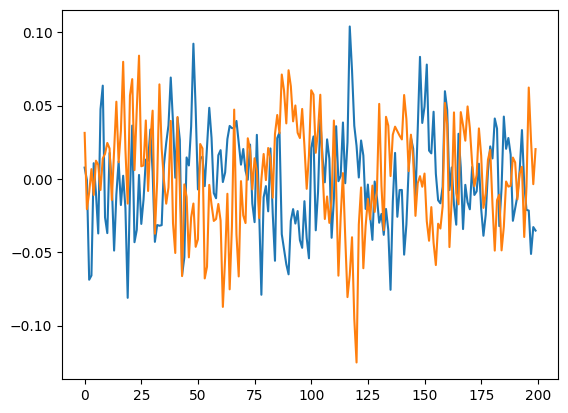

In [40]:
plt.plot(realbbh[10, 0])
plt.plot(realbbh[10, 1])

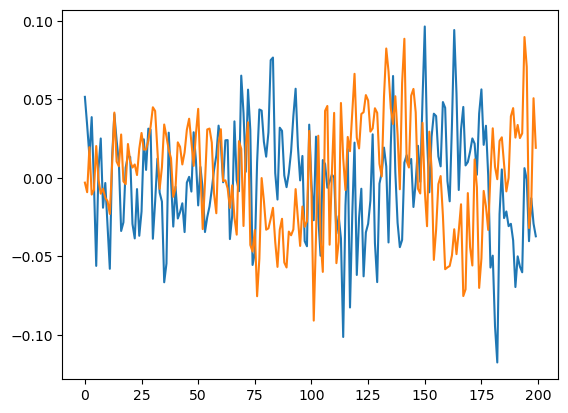

In [27]:
plt.plot(realbbh[0, 0])
plt.plot(realbbh[0, 1])

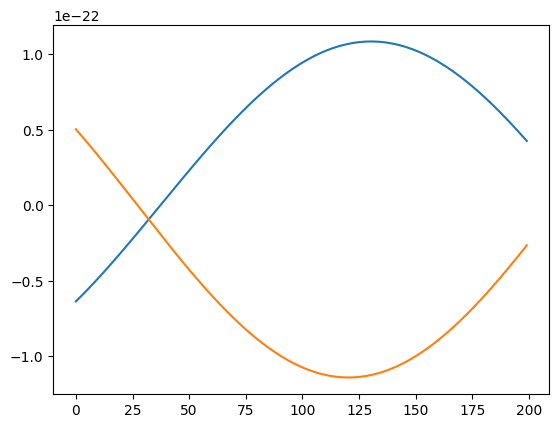

In [42]:
plt.plot(purebbh[0, 0])
plt.plot(purebbh[0, 1])

In [61]:
realbkg_cut_normalized_trimmed = np.hstack((bunch_normalization(realbkg[:,0,50:150])[0],bunch_normalization(realbkg[:,1,50:150])[0]))

In [62]:
np.linalg.norm(realbkg_cut_normalized_trimmed[10])

1.4142135623730951

In [51]:
pure_bbh_normalized = np.hstack((bunch_normalization(purebbh[:,0,50:150])[0], bunch_normalization(purebbh[:,1,50:150])[0]))

In [52]:
pure_bbh_normalized.shape

(1000000, 200)

In [53]:
np.linalg.norm(pure_bbh_normalized[10])

1.4142135623730951

In [10]:
realbbh_trimmed = np.hstack((realbbh[:, 0, 50:150], realbbh[:, 1, 50:150]));
realbkg_trimmed = np.hstack((realbkg[:, 0, 50:150], realbkg[:, 1, 50:150]));

In [31]:
np.linalg.norm(realbkg_cut_normalized_trimmed[0])

1.414213562373095

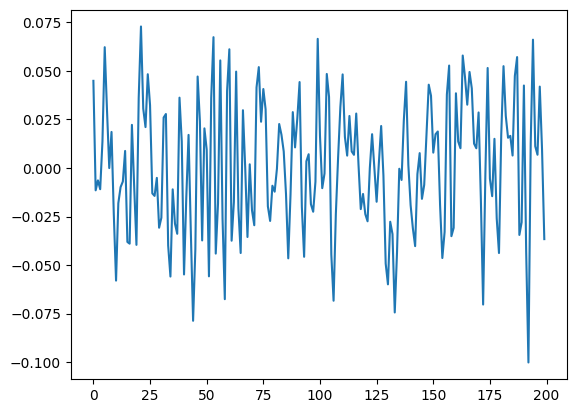

In [29]:
plt.plot(realbkg_trimmed[0])

In [63]:
# nTotal = len(bkg);
nTotal = len(realbkg_cut_normalized_trimmed);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

X_train = realbkg_cut_normalized_trimmed[perm[:nTrain]]
X_test = realbkg_cut_normalized_trimmed[perm[-nTest:]]
X_validation = realbkg_cut_normalized_trimmed[perm[nTrain:-nTest]]

# X_train, _, _ = bunch_normalization(X_train)
# X_test, _, _ = bunch_normalization(X_test)
# X_validation, _, _ = bunch_normalization(X_validation)

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

In [64]:
X_train.shape

(700000, 200)

In [ ]:
X_train

In [65]:
# Start training

autoencoder = TwoDetectorDNN(100, 35, 5).cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))

for epoch in range(epochs):

    t0 = time.time()
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        decoded = autoencoder(x)
        loss_overall = loss_func(decoded, x)
#         loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall #+ loss_norm * wNorm

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
#             lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall #+ lossVal_norm * wNorm
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))
    print(time.time() - t0)

# print(time.time() - t0)
# print("Norm weight %f done training" % (wNorm,))
# print(autoencoder.cuda())
# torch.save(autoencoder.cuda(), "../data/model_201-40_weight_%f_fakebkg.pt" % (wNorm,))
# np.savetxt("../data/loss_201-40_weight_%f_fakebkg.dat" % (wNorm,), [loss_train[:, 0], loss_validation[:, 0]])
    
# np.savetxt("../data/perm_fakebkg.dat", perm)

Epoch: 0001, Training loss=0.00433842, Validation loss=0.00406377
32.50491213798523
Epoch: 0002, Training loss=0.00366948, Validation loss=0.00378673
33.136183738708496
Epoch: 0003, Training loss=0.00380829, Validation loss=0.00370291
33.23524856567383
Epoch: 0004, Training loss=0.00371428, Validation loss=0.00367849
33.31523680686951
Epoch: 0005, Training loss=0.00387456, Validation loss=0.00366889
33.19489407539368
Epoch: 0006, Training loss=0.00379391, Validation loss=0.00366440
33.1280403137207
Epoch: 0007, Training loss=0.00357945, Validation loss=0.00366210
33.179094314575195
Epoch: 0008, Training loss=0.00351885, Validation loss=0.00366024
32.77000451087952
Epoch: 0009, Training loss=0.00375771, Validation loss=0.00365881
32.91455006599426
Epoch: 0010, Training loss=0.00365614, Validation loss=0.00365687
31.923482418060303
Epoch: 0011, Training loss=0.00352253, Validation loss=0.00365635
32.041528940200806
Epoch: 0012, Training loss=0.00365078, Validation loss=0.00365604
32.1907

In [66]:
torch.save(autoencoder.cpu(),'../Model_cached/model_2detDNN_Jiarui_noise_40_latentspace.pt')

In [67]:
# Start training

autoencoder = TwoDetectorDNN(100, 20, 5).cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))

for epoch in range(epochs):

    t0 = time.time()
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        decoded = autoencoder(x)
        loss_overall = loss_func(decoded, x)
#         loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall #+ loss_norm * wNorm

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
#             lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall #+ lossVal_norm * wNorm
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))
    print(time.time() - t0)

# print(time.time() - t0)
# print("Norm weight %f done training" % (wNorm,))
# print(autoencoder.cuda())
# torch.save(autoencoder.cuda(), "../data/model_201-40_weight_%f_fakebkg.pt" % (wNorm,))
# np.savetxt("../data/loss_201-40_weight_%f_fakebkg.dat" % (wNorm,), [loss_train[:, 0], loss_validation[:, 0]])
    
# np.savetxt("../data/perm_fakebkg.dat", perm)

Epoch: 0001, Training loss=0.00462114, Validation loss=0.00467390
65.99409604072571
Epoch: 0002, Training loss=0.00471673, Validation loss=0.00456803
66.02319049835205
Epoch: 0003, Training loss=0.00443306, Validation loss=0.00454237
65.45247483253479
Epoch: 0004, Training loss=0.00440423, Validation loss=0.00452513
66.24284410476685
Epoch: 0005, Training loss=0.00447494, Validation loss=0.00452008
66.01246500015259
Epoch: 0006, Training loss=0.00456483, Validation loss=0.00451596
65.40202045440674
Epoch: 0007, Training loss=0.00454071, Validation loss=0.00451482
65.71161723136902
Epoch: 0008, Training loss=0.00435057, Validation loss=0.00451233
65.85907649993896
Epoch: 0009, Training loss=0.00464038, Validation loss=0.00451261
66.07457208633423
Epoch: 0010, Training loss=0.00500908, Validation loss=0.00451098
67.65377354621887
Epoch: 0011, Training loss=0.00459514, Validation loss=0.00451005
67.73643493652344
Epoch: 0012, Training loss=0.00432712, Validation loss=0.00450949
67.3668718

In [68]:
torch.save(autoencoder.cpu(),'../Model_cached/model_2detDNN_Jiarui_noise_25_latentspace.pt')

In [33]:
realbbh_trimmed.shape

(100000, 200)

In [43]:
autoencoder.eval()

reconstructed_bbh_trimmed = autoencoder(torch.FloatTensor(realbbh_trimmed).cuda()).cpu().double().detach().numpy();
reconstructed_bkg_trimmed = autoencoder(torch.FloatTensor(realbkg_trimmed).cuda()).cpu().double().detach().numpy();

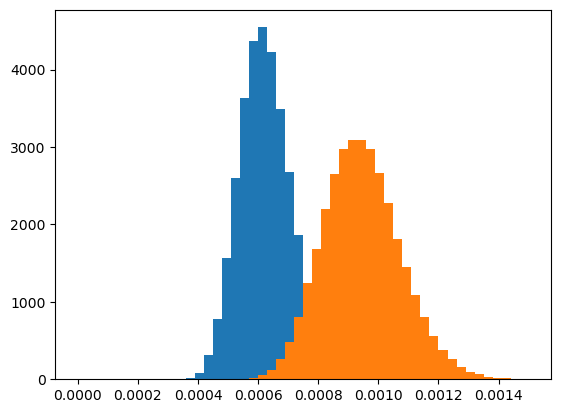

In [57]:
foo = plt.hist(np.linalg.norm(reconstructed_bbh_trimmed-realbbh_trimmed, axis=1)**2/200, bins=50, range=(0., 0.0015), density=True)
foo = plt.hist(np.linalg.norm(reconstructed_bkg_trimmed-realbkg_trimmed, axis=1)**2/200, bins=50, range=(0., 0.0015), density=True)

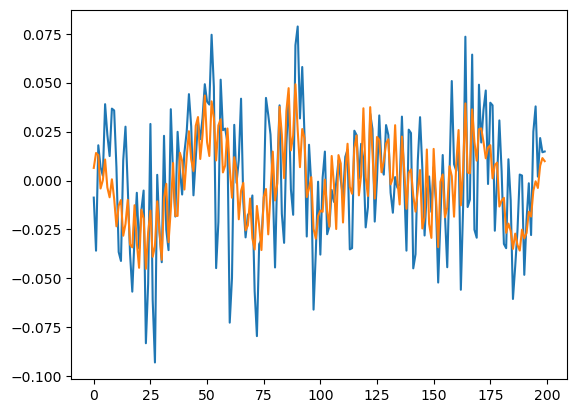

In [42]:
ind = np.random.randint(0, len(realbbh_trimmed))
plt.plot(realbbh_trimmed[ind])
plt.plot(reconstructed_bbh_trimmed[ind])